In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from mlxtend.classifier import StackingClassifier
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, recall_score, f1_score, precision_score

import eli5
from eli5.sklearn import PermutationImportance
%matplotlib inline
%config InlineBackend.figure_format = 'svg'  # 图片输出为矢量图，保证清晰度

Using TensorFlow backend.


### 导入数据+初始化+划分训练集测试集

In [24]:
data = pd.read_csv("./RNA_seq.csv")
dataT=np.array(data)
data=dataT.T
co=data[0]
data1=np.delete(data,0,axis=0)
data=data1
datadf= pd.DataFrame(data=data[0:,0:],columns=co)
datadf.head()
data=datadf
data= data.replace("NOTLC",value=0)
data= data.replace("LC",value=1)
X=data.drop(['Group'],axis=1)
y=data['Group']

In [14]:
column=X.columns
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(data=X,columns=column)

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=None)
print(f'Train shape : {X_train.shape}\nTest shape: {X_test.shape}')

Train shape : (878, 60660)
Test shape: (220, 60660)


### 集成模型

In [4]:
from sklearn.base import ClassifierMixin
from sklearn.base import TransformerMixin, BaseEstimator
class MyEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, model, mask) -> None:
        super().__init__()
        self.mask = mask
        self.model = model
    
    def fit(self, X, y=None):
        self.model.fit(X[self.mask],y)
        return self

    def predict(self, X):
        return self.model.predict(X[self.mask])
    
    def predict_proba(self, X):
        return self.model.predict_proba(X[self.mask])
        

In [5]:
from itertools import *
sel_seq_dt_mask=['ENSG00000003147.19','ENSG00000004455.17','ENSG00000006327.14','ENSG00000018510.17','ENSG00000067064.11','ENSG00000154813.10','ENSG00000204305.14','ENSG00000234425.1','ENSG00000262772.2','ENSG00000272477.1']
sel_seq_rf_mask=['ENSG00000106089.12', 'ENSG00000204305.14', 'ENSG00000223982.3','ENSG00000229693.2']
sel_seq_ada_mask=['ENSG00000000005.6', 'ENSG00000002933.9','ENSG00000019144.19', 'ENSG00000070366.14','ENSG00000091262.16','ENSG00000106089.12','ENSG00000204305.14','ENSG00000233117.4']
sel_seq_gb_mask=['ENSG00000000005.6','ENSG00000000971.16', 'ENSG00000001631.16','ENSG00000002587.10', 'ENSG00000004779.10','ENSG00000106089.12', 'ENSG00000144130.11', 'ENSG00000204305.14']
sel_seq_xgb_mask=['ENSG00000008128.23','ENSG00000106089.12','ENSG00000170989.10','ENSG00000006327.14','ENSG00000018510.17','ENSG00000204305.14',]
sel_seq_KN_mask=['ENSG00000223982.3', 'ENSG00000229693.2', 'ENSG00000091262.16','ENSG00000204305.14', 'ENSG00000004399.13', 'ENSG00000039068.19']
sel_seq_Lightgbm_mask=['ENSG00000106089.12', 'ENSG00000170989.10','ENSG00000204305.14']
sel_seq_SVC_mask=['ENSG00000223982.3','ENSG00000002726.21','ENSG00000039068.19','ENSG00000106089.12','ENSG00000182685.7','ENSG00000154813.10','ENSG00000204305.14' ,'ENSG00000135604.10', 'ENSG00000004399.13','ENSG00000000003.15']
sel_seq_GNB_mask=['ENSG00000000938.13', 'ENSG00000004399.13','ENSG00000166123.14', 'ENSG00000204305.14', 'ENSG00000211643.2','ENSG00000259884.1', 'ENSG00000279940.1']
sel_seq_lr_mask=['ENSG00000102547.19','ENSG00000135604.10','ENSG00000159352.16','ENSG00000224215.1','ENSG00000234481.2','ENSG00000252275.1','ENSG00000271555.1']
model_dt_fs = MyEstimator(DecisionTreeClassifier(max_depth=8,min_samples_leaf=1,min_samples_split=4), sel_seq_dt_mask)
model_rf_fs = MyEstimator(RandomForestClassifier(max_depth=4,n_estimators=108,n_jobs=-1,random_state=90), sel_seq_rf_mask)
model_ada_fs = MyEstimator(AdaBoostClassifier(learning_rate=1,n_estimators=50), sel_seq_ada_mask)
model_gb_fs = MyEstimator(GradientBoostingClassifier(learning_rate=0.01,loss='exponential',n_estimators=300), sel_seq_gb_mask)
model_xgb_fs = MyEstimator(XGBClassifier(booster='gbtree',learning_rate=0.01,max_depth=5,n_estimators=400), mask=sel_seq_xgb_mask)
model_KN_fs = MyEstimator(KNeighborsClassifier(n_neighbors=5), mask=sel_seq_KN_mask)
model_Lightgbm_fs = MyEstimator(lgb.LGBMClassifier(max_depth=6,n_estimators=200), mask=sel_seq_Lightgbm_mask)
model_SVC_fs = MyEstimator(SVC(kernel="poly",degree=3,coef0=1,probability=True),mask=sel_seq_SVC_mask)
model_GNB_fs = MyEstimator(GaussianNB(),mask=sel_seq_GNB_mask)
model_lr_fs = MyEstimator(LogisticRegression(C=0.01),mask=sel_seq_lr_mask)
feature=list(set(sel_seq_dt_mask+sel_seq_rf_mask+sel_seq_ada_mask+sel_seq_GNB_mask+sel_seq_xgb_mask))

from sklearn.ensemble import VotingClassifier
model_voting = VotingClassifier([
    ("dt",model_dt_fs),
    ("rf",model_rf_fs ),
    ("ada", model_ada_fs),
    ("gnb",model_GNB_fs),
    ("xgb", model_xgb_fs)
], voting="hard")

### Permutation Importance

In [9]:
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
my_model = model_voting.fit(X_train, y_train)

In [7]:
perm = PermutationImportance(my_model, random_state=42).fit(X_test, y_test)
feature_names = X_test.columns.tolist()
show_weights(perm, feature_names=feature_names)

Weight,Feature
0.1045 ± 0.0057,ENSG00000204305.14
0.0291 ± 0.0045,ENSG00000106089.12
0 ± 0.0000,ENSG00000205572.10
0 ± 0.0000,ENSG00000205622.11
0 ± 0.0000,ENSG00000205611.5
0 ± 0.0000,ENSG00000205609.13
0 ± 0.0000,ENSG00000205596.4
0 ± 0.0000,ENSG00000205593.12
0 ± 0.0000,ENSG00000205592.15
0 ± 0.0000,ENSG00000205584.6


### PDP

In [6]:
from pdpbox import pdp,get_dataset,info_plots

In [7]:
feature_names=X.columns

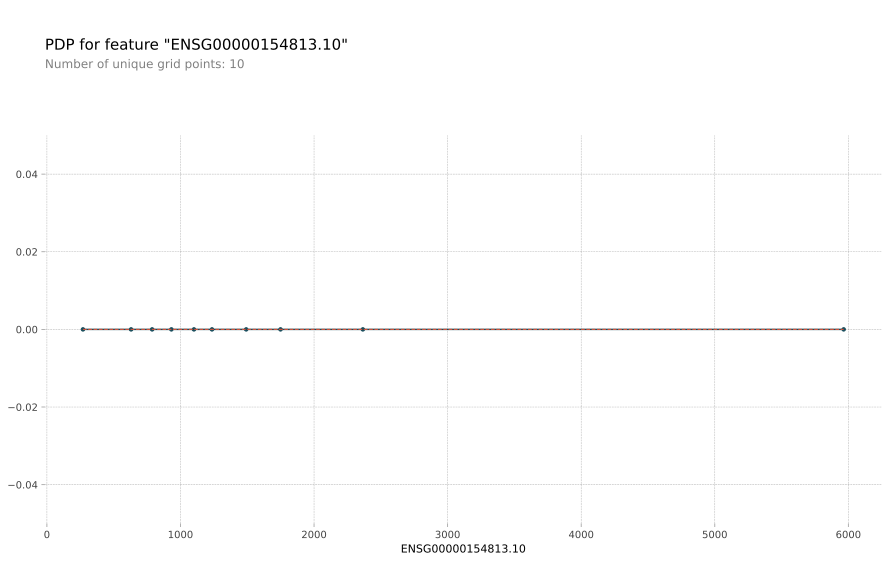

In [39]:
feature_to_plot='ENSG00000154813.10'
pdp_list=pdp.pdp_isolate(model=my_model,dataset=X_test,model_features=feature_names,feature=feature_to_plot)
pdp.pdp_plot(pdp_list,feature_to_plot)
plt.savefig('./image/PDP_single_ENSG00000154813.10.png', dpi=500, bbox_inches='tight') 
plt.show()

In [ ]:
'ENSG00000204305.14''ENSG00000106089.12''ENSG00000138346.15'

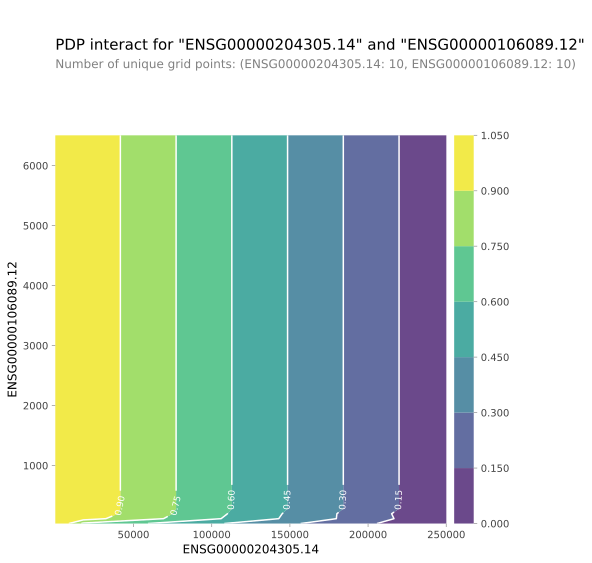

In [51]:
features_to_plot=['ENSG00000204305.14','ENSG00000106089.12']
inter1=pdp.pdp_interact(model=my_model,dataset=X_test,model_features=feature_names,features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1,feature_names=features_to_plot)
plt.savefig('./image/PDP_two_ENSG00000204305.14_ENSG00000106089.12.png', dpi=500, bbox_inches='tight') 
plt.show()